In [5]:
import numpy as np
import pandas as pd

import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2

from pathlib import Path

In [2]:
# 查看数据
dir_path = "./xray_dataset/"
print(os.listdir(dir_path))

['test', 'train']


In [4]:
# 划分训练和测试集
base_dir = "./xray_dataset/"
train_dir = base_dir + "train/"
test_dir = base_dir + "test"

In [8]:
# 定义一个读取文件并将其划分为dataframe
def get_df(path):
    lst = []
    normal_dir = Path(path + "NORMAL")
    pneumonia_dir = Path(path + "PNEUMONIA")
    
    normal_data = normal_dir.glob("*.jpeg")
    pneumonia_data = pneumonia_dir.glob("*.jpeg")
    
    for fname in normal_data:
        lst.append((fname,0))
    for fname in pneumonia_data:
        lst.append((fname,1))
    
    df = pd.DataFrame(lst,columns=["Image","Label"],index=None)
    
    s = np.arange(df.shape[0])
    np.random.shuffle(s)
    df = df.iloc[s,:].reset_index(drop=True)
    
    return df

In [9]:
df_train = get_df(train_dir)

In [10]:
df_train.head()

,Image,Label
0,xray_dataset\train\PNEUMONIA\2985.jpeg,1
1,xray_dataset\train\PNEUMONIA\3869.jpeg,1
2,xray_dataset\train\PNEUMONIA\2470.jpeg,1
3,xray_dataset\train\NORMAL\1037.jpeg,0
4,xray_dataset\train\PNEUMONIA\3217.jpeg,1


In [12]:
df_train["Label"].value_counts()

1    2987
0    1112
Name: Label, dtype: int64

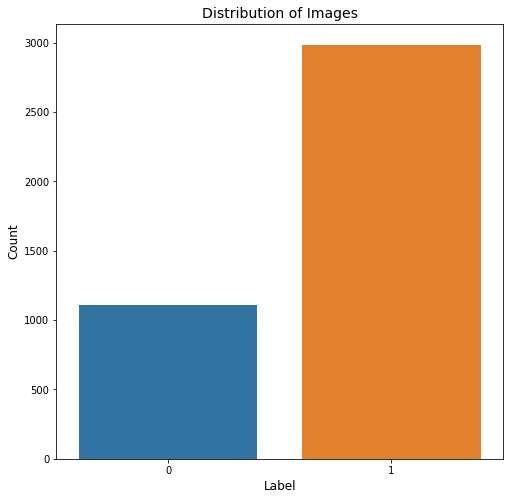

In [13]:
fig,ax = plt.subplots(figsize=(8,8))
sns.countplot(df_train["Label"])
ax.set_title("Distribution of Images",fontsize=14)
ax.set_xlabel("Label",fontsize=12)
ax.set_ylabel("Count",fontsize=12)
plt.show()

In [16]:
# 定义读取文件的函数以及数据增强
from imgaug import augmenters as iaa

def transform_image(img_list):
    img = cv2.resize(img_list,(224,224))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

def augment_image(img_list):
    seq = iaa.OneOf([
        iaa.Affine(
            scale={"x":(0.8,1.2),"y":(0.8,1.2)},
            rotate=(-25,25)
        ),
        iaa.Fliplr(),
        iaa.Multiply((1.2,1.5))
    ])
    return seq.augment_image(img_list)

def transform_augment_batch(img_path_list,label_list,is_augment=False):
    img_list = []
    for i in range(len(img_path_list)):
        img_list.append(transform_image(cv2.imread(str(img_path_list[i]))))
    n = len(img_list)
    if is_augment:
        for i in range(n):
            img = img_list[i]
            img = augment_image(img)
            img_list.append(img)
        img_list = np.array(img_list)
        label_list = np.append(label_list,label_list)
    return img_list,label_list

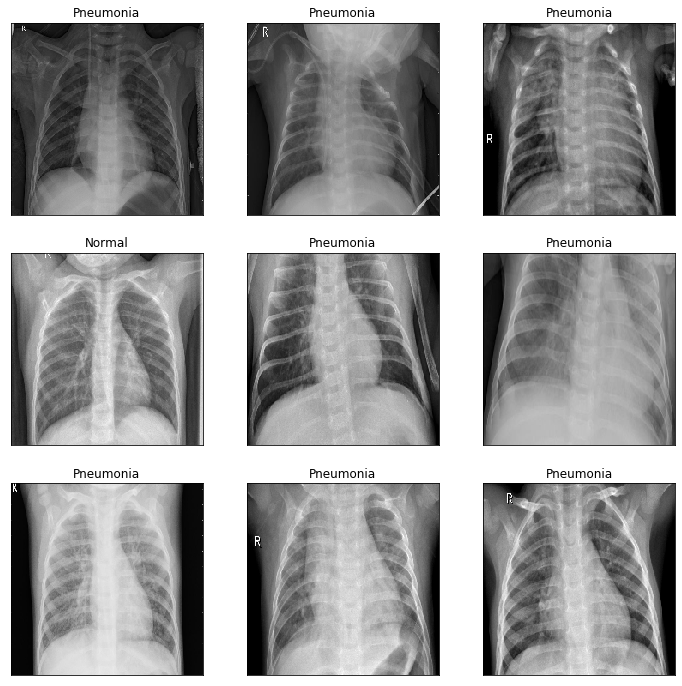

In [17]:
plt.ax = plt.subplots(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i,0])))
    plt.imshow(img)
    if df_train.iloc[i,1] == 0:
        plt.title("Normal")
    else:
        plt.title("Pneumonia")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
# 导入数据
train_images,train_labels = transform_augment_batch(df_train.iloc[:,0],df_train[:,1],True)
train_images = np.array(train_images)

In [24]:
train_labels = train_labels.reshape(train_labels.shape[0],1)

In [25]:
train_images.shape,train_labels.shape

((8198, 224, 224, 3), (8198, 1))